# <center> Отбор и селекция признаков. Практика

## <center> Предсказание цены автомобиля

### Постановка задачи

Обучите модель линейной регрессии на найденных двумя способами трёх важных признаках и сравните полученные результаты.

In [123]:
import pandas as pd
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import r2_score

Считывание данных:

In [124]:
data = pd.read_excel('./data/data_ford_price.xlsx')
data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


В рамках занятия '9. Отбор признаков: классификация методов' в тренировочной выборке присутствуют признаки: 
- 'year',
- 'cylinders',
- 'odometer',
- 'lat',
- 'long',
- 'weather'.

Очистка от пропусков, разделение факторов и целевого признака:

In [125]:
data = data[['year', 'cylinders', 'odometer', 'lat', 'long', 'weather', 'price']].dropna()
X = data[['year', 'cylinders', 'odometer', 'lat', 'long', 'weather']]
y = data['price']

Разделение выборки на тренировочную и тестовую в соотношении 80/20:

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Выделение столбцов-признаков для обучения с использованием RFE

Выделение трех наиболее значимых факторов:

In [127]:
estimator = LinearRegression()
selector_RFE = RFE(estimator, n_features_to_select=3, step=1)
selector_RFE = selector_RFE.fit(X_train, y_train)
 
print(*selector_RFE.get_feature_names_out(), sep='\n')

year
cylinders
lat


Визуализация ранжировки факторов:

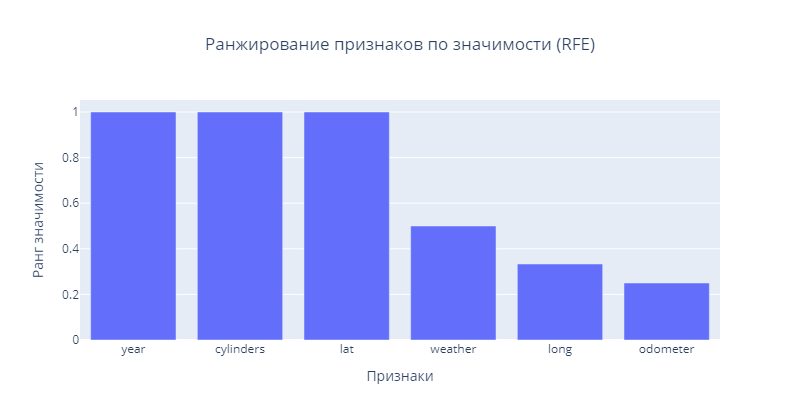

In [128]:
show_data = pd.DataFrame()
show_data['col'], show_data['rank'] = X_train.columns, 1 / selector_RFE.ranking_
fig = go.Figure(data=[go.Bar(x=show_data.sort_values(by='rank', ascending=False)['col'],
                             y=show_data.sort_values(by='rank', ascending=False)['rank'])])
fig.update_layout(title=f'Ранжирование признаков по значимости (RFE)',
                  title_x=0.5, # Выравнивание заголовка посередине
                  xaxis_title='Признаки', # Подпись Х
                  yaxis_title='Ранг значимости') # Подпись Y
fig.update_layout(autosize = False, width = 800, height = 420)
fig.show('png')

### Выделение столбцов-признаков для обучения с использованием SelectKBest

Выделение трех наиболее значимых факторов:

In [129]:
selector_KBest = SelectKBest(f_regression, k=3)
selector_KBest.fit(X_train, y_train)
 
print(*selector_KBest.get_feature_names_out(), sep='\n')

year
cylinders
odometer


Визуализация оценки значимости факторов:

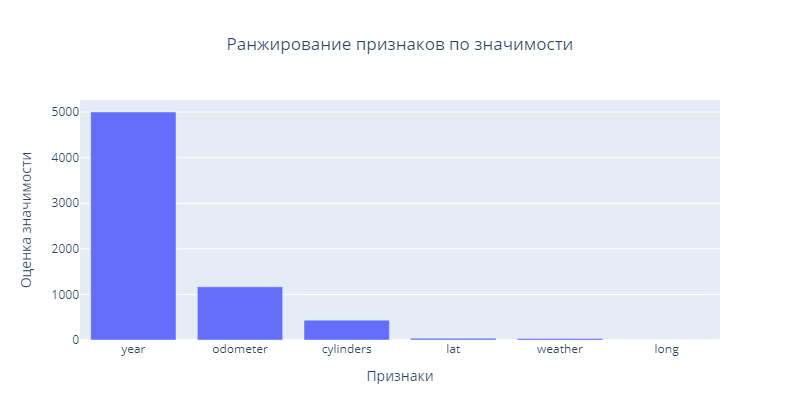

In [130]:
show_data = pd.DataFrame()
show_data['col'], show_data['rank'] = X_train.columns, selector_KBest.scores_
fig = go.Figure(data=[go.Bar(x=show_data.sort_values(by='rank', ascending=False)['col'],
                             y=show_data.sort_values(by='rank', ascending=False)['rank'])])
fig.update_layout(title=f'Ранжирование признаков по значимости',
                  title_x=0.5, # Выравнивание заголовка посередине
                  xaxis_title='Признаки', # Подпись Х
                  yaxis_title='Оценка значимости') # Подпись Y
fig.update_layout(autosize = False, width = 800, height = 420)
fig.show('png')

---
Для оценки качества моделей выбираем коэффициент детерминации ($R^2$), так как он является стандартным показателем для линейных моделей и его легко интерпретировать.

### Обучение регрессии и оценка качества модели, используя признаки, выделенные методом RFE

In [131]:
model_lr_RFE = LinearRegression()
model_lr_RFE.fit(X_train[selector_RFE.get_feature_names_out()], y_train)
y_train_predict = model_lr_RFE.predict(X_train[selector_RFE.get_feature_names_out()])
y_test_predict = model_lr_RFE.predict(X_test[selector_RFE.get_feature_names_out()])
r2_train_RFE = r2_score(y_train, y_train_predict)
r2_test_RFE = r2_score(y_test, y_test_predict)
print(f'R^2 тренировочной выборки: {r2_train_RFE:.3f}')
print(f'R^2 тестовой выборки: {r2_test_RFE:.3f}')

R^2 тренировочной выборки: 0.495
R^2 тестовой выборки: 0.562


### Обучение регрессии и оценка качества модели, используя признаки, выделенные методом SelectKBest

In [132]:
model_lr_KBest = LinearRegression()
model_lr_KBest.fit(X_train[selector_KBest.get_feature_names_out()], y_train)
y_train_predict = model_lr_KBest.predict(X_train[selector_KBest.get_feature_names_out()])
y_test_predict = model_lr_KBest.predict(X_test[selector_KBest.get_feature_names_out()])
r2_train_KBest = r2_score(y_train, y_train_predict)
r2_test_KBest = r2_score(y_test, y_test_predict)
print(f'R^2 тренировочной выборки: {r2_train_KBest:.3f}')
print(f'R^2 тестовой выборки: {r2_test_KBest:.3f}')

R^2 тренировочной выборки: 0.522
R^2 тестовой выборки: 0.598


### Сравнение метрик качества моделей

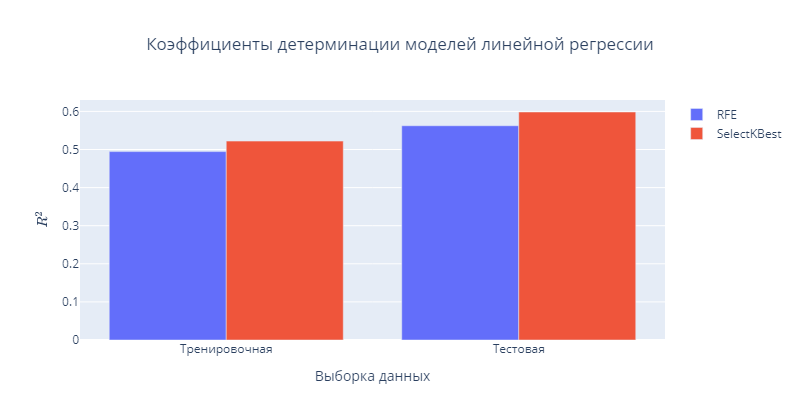

In [133]:
# Построение диаграммы рассеяния
fig = go.Figure()
# Посторение линии опыт=возраст
fig.add_trace(go.Bar(x=['Тренировочная', 'Тестовая'],
                         y=[r2_train_RFE, r2_test_RFE],
                         name='RFE'))
# Построение оценочных пограничных линий
fig.add_trace(go.Bar(x=['Тренировочная', 'Тестовая'],
                         y=[r2_train_KBest, r2_test_KBest],
                         name='SelectKBest'))
fig.update_layout(title=f'Коэффициенты детерминации моделей линейной регрессии',
                  title_x=0.5, # Выравнивание заголовка посередине
                  xaxis_title='Выборка данных', # Подпись Х
                  yaxis_title='$R^2$') # Подпись Y
fig.update_layout(autosize = False, width = 800, height = 420)
fig.show('png')

Как на тренировочной, так и на тестовой выборках более высокое значение метрики ($R^2$) показала модель линейной регрессии, обученная на признаках, выбранных методом отбора признаков "Выбор k лучших переменных" (SelectKBest), таким образом, в данном случае этот метод более объективно оценил степень влияния факторов на целевой признак.